NIfTI (Neuroimaging Informatics Technology Initiative) is a common file format for storing neuroimaging data.
It allows to:
- store multi-dimensional arrays (3D or 4D).
- store header information about voxel dimensions, data type, and spatial orientation.

It is usually saved in `.nii` or compressed `.nii.gz` extensions.

Let's install the needed packages

In [1]:
# %%
# !pip install nibabel nilearn antspyx

And download some dataset as example -> IXI

In [2]:
# If for personal interest you want to download the unprocessed IXI...

# !wget -nc http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar -O ../data/IXI-T1.tar
# !mkdir ../data/IXI
# !wget -nc http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI.xls -O ../data/IXI/IXI.xls
# !tar -xvf ../data/IXI-T1.tar -C ../data/IXI

In [3]:
# We download instead a preprocessed version (will be explained...)
#!mkdir ../data
#!curl -L -o ../data/preprocessed-ixi-dataset-with-fs8.zip -z ../data/preprocessed-ixi-dataset-with-fs8.zip https://www.kaggle.com/api/v1/datasets/download/kingpowa/preprocessed-ixi-dataset-with-fs8
#!unzip -n ../data/preprocessed-ixi-dataset-with-fs8.zip -d ../data
#!mkdir ../data/IXI
#!mv -v ../data/T1w_Processed_IXI_with_csv/IXI/* ../data/IXI
#!rm -rf ../data/preprocessed-ixi-dataset-with-fs8.zip
#!rm -rf ../data/T1w_Processed_IXI_with_csv

In [4]:
## Imports
import os
# Brain manip
import nibabel as nib # <- Library for handling nifti files
import numpy as np
import ants
from nilearn import image
from nilearn import masking
import nilearn
# Plotting 
from nilearn import plotting
import matplotlib.pyplot as plt
# Visualize
from nibabel.freesurfer.io import read_morph_data
import pandas as pd

Let's visualize an example of a nifti file from the IXI files

In [5]:
example_image = "../data/example_data/sub-IXI002_acq-Philips-1.5T_T1w.nii.gz"
brain_nii = nib.load(example_image)
header = brain_nii.header

print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.        0.9375    0.9375    1.199997  0.        0.        0.
  0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'MR'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.468175
quatern_c       : -0.5299171
quatern_d       : -0.468175
qoffset_x       : -88.63989
qoffset_y       : 116.

In [6]:
brain = brain_nii.get_fdata()
print(f"Data shape: {brain.shape}")
print(f"Voxel dimensions: {header.get_zooms()}") # This how relates each voxels in mm in real life

Data shape: (256, 256, 150)
Voxel dimensions: (0.9375, 0.9375, 1.199997)


We can quickly visualize the brain via `matplotlib`...

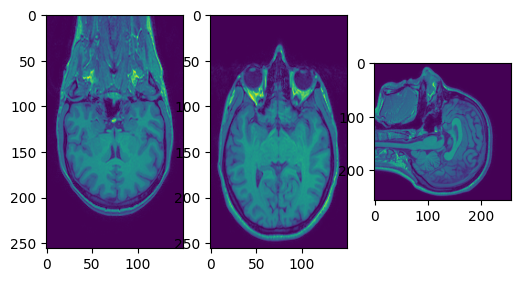

In [7]:
def show_brain(brain: np.ndarray):
    fig, ax = plt.subplots(1,3,figsize=(6,18))
    plot_points = [x//2 for x in brain.shape[-3:]]
    ax[0].imshow(brain[plot_points[0]])
    ax[1].imshow(brain[:,plot_points[1]])
    ax[2].imshow(brain[:,:,plot_points[2]])
    plt.show()

show_brain(brain)

As you can see, plotting with simple library does not take into account the affine properties of the brain.

`nilearn` allows us to overcome this problem as it is specialised for brain visualisation.

/tmp/ipykernel_131792/206455878.py:1: UserWarning: Casting data from int32 to float32
  plotting.plot_anat(brain_nii,


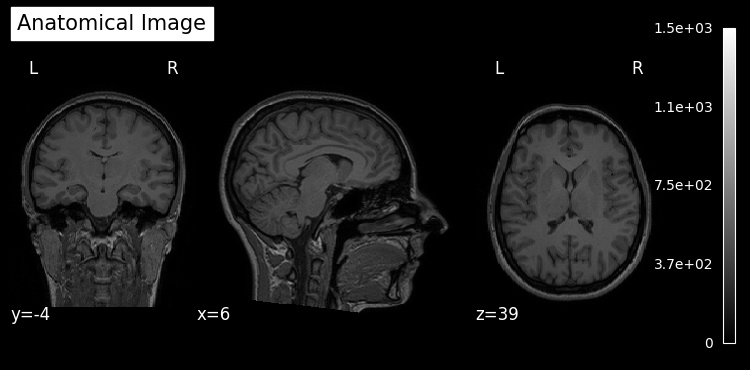

In [8]:
plotting.plot_anat(brain_nii, 
                   title='Anatomical Image', 
                   display_mode='ortho', # <-- display all the slices orientations
                   draw_cross=False) # <-- Do not draw a cross showing the cut      
plotting.show()

In order to execute many pipelines in the Machine Learning (ML) domain, it is important to preprocess this type of data, i.e. apply standardised operation that allows to align the images to common standards.

An usual pipeline consists in aligning the brain to a known template. It is a digital‐image reference that represents the average of the brain. The MNI152 is a very well known brain template, and we can take it as an example. Let's visualize it.

We can download it from the github repo [MNITemplate](https://github.com/Jfortin1/MNITemplate)

In [9]:
!wget -nc https://github.com/Jfortin1/MNITemplate/raw/refs/heads/master/inst/extdata/MNI152_T1_1mm.nii.gz -O ../data/MNI152_T1_1mm.nii.gz

File ‘../data/MNI152_T1_1mm.nii.gz’ already there; not retrieving.


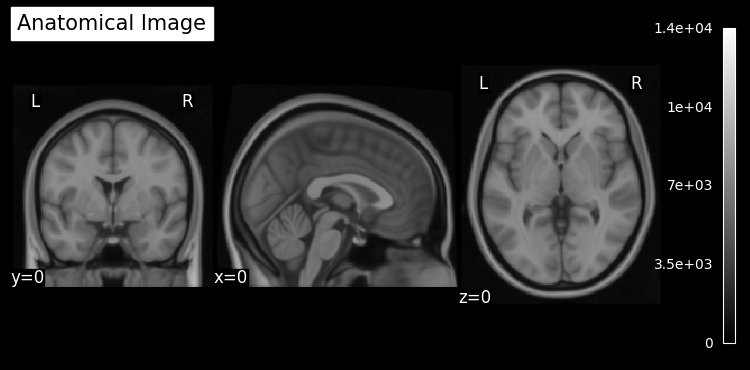

In [10]:
# The atlas can be obtained via nilearn
mni152_template = nib.load("../data/MNI152_T1_1mm.nii.gz")
plotting.plot_anat(mni152_template, 
                   cut_coords=(0,0,0),
                   title='Anatomical Image', 
                   display_mode='ortho',
                   draw_cross=False)
plotting.show()

In many ML pipelines, the images are "registered" to this template.

Registering a brain means finding and applying a spatial transform that warps the MRI to a predefined coordinate space. In other words, we modify the spatial position (or structure) of the brain so that it is aligned as the known template.

This is done because in ML having a structure input is much more beneficial for many algorithms, providing fewer variables to learn.

`ants` allows to execute easily a "linear" registration. A linear registration simply performs an affine transformation (i.e. rotation, scaling...), without modifying the structure of the tissues. This can be useful if we want to keep the structure of the brain intact for keeping individual differences.
This also allows to adapt the spatial meaning of the pixels of the two brains.

In [11]:
# As we see, the zooms of the mni152_template are different
mni152_template.header.get_zooms()

(1.0, 1.0, 1.0)

In [12]:
original_brain = ants.image_read(example_image)
ants_template = ants.image_read("../data/MNI152_T1_1mm.nii.gz")

In [13]:
reg = ants.registration(
    fixed=ants_template,
    moving=original_brain,
    type_of_transform="Affine", # By selecting this option, we obtain the registration on 12 degrees of freedom
    outprefix="t1_to_mni_"
)

In [14]:
# We apply now the transformation, contained in the object created before
moving_in_mni = ants.apply_transforms(
    fixed=ants_template,
    moving=original_brain,
    transformlist=reg["fwdtransforms"],    # forward affine
    interpolator="linear"                   # use 'nearestNeighbor' for labels/segmentations
)
ants.image_write(moving_in_mni, "../data/example_data/sub-IXI002_acq-Philips-1.5T_T1w_mni_registered.nii.gz")

In [15]:
# We go back to nibabel format now
registered_brain_nii = nib.load("../data/example_data/sub-IXI002_acq-Philips-1.5T_T1w_mni_registered.nii.gz")

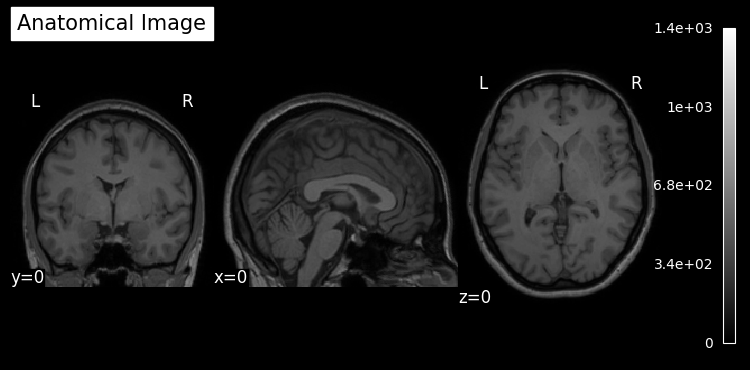

In [16]:
# It is now aligned to the same orientation of the template
plotting.plot_anat(registered_brain_nii, 
                   cut_coords=(0,0,0),
                   title='Anatomical Image', 
                   display_mode='ortho',
                   draw_cross=False) 
plotting.show()

After registration, usually a "skullstripping" operation is executed. Skullstripping is an operation that allows to remove any elements from the original image that is not belonging to the brain tissue. For instance, it removes the skull or other elements. This allows to better process the brain for other tasks.
Skullstripping is a complex operation, usually performed with specialised tools.

`nilearn` provides a basic function we can use as an example to show what's the typical output of this process.

In [17]:
brain_mask_estimation_nii = masking.compute_brain_mask(registered_brain_nii)
brain_skullstripped_nii = image.math_img("img * mask", img=registered_brain_nii, mask=brain_mask_estimation_nii)

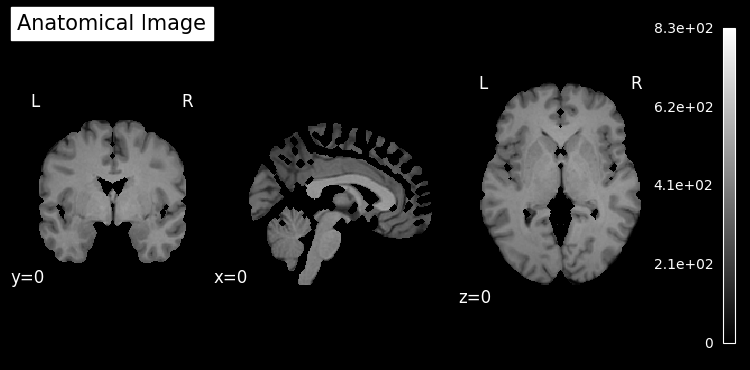

In [18]:
plotting.plot_anat(brain_skullstripped_nii, 
                   cut_coords=(0,0,0),
                   title='Anatomical Image', 
                   display_mode='ortho',
                   draw_cross=False) 
plotting.show()

As you see, the results is not precise. This is because many possible problems are present in the images:
- a very aggressive bias field (slow intensity drift)
- low contrast
- ecc...
`nilearn` is also not very specialised on skullstripping process. However, this gives you an intuition on how this process is performed.

A very well known skullstripping program is Freesurfer. It is an open-source software which is also used for other tasks, such as cortical thickness calculation and estimation, volumetric seg., ecc...

The repo we downloaded contains a preprocessd set of IXI files via `freesurfer`

Let's see the difference with what we have done here.

First, let's analyze the csv

Exercise:

You have a folder `../data/IXI` that contains a csv.

1 - Open the CSV and locate the candidate scans

2 - visualize it

3 - write a function to plot the differences between the brain you have and the one we skullstripped. What do you notice?

In [19]:
masterfile_path = "../data/IXI/subjects.csv"
masterfile = pd.read_csv(masterfile_path)
masterfile.head(5)

,subject_id,age,sex,scanner,site,diagnosis,dataset_name,subject_key,session,run,registered_mni
0,IXI002,35.80,Female,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,IXI002_IXI,1,1,sub-IXI002/ses-1/run-1/anat/sub-IXI002_acq-Phi...
1,IXI012,38.78,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI012_IXI,1,1,sub-IXI012/ses-1/run-1/anat/sub-IXI012_acq-Phi...
2,IXI013,46.71,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI013_IXI,1,1,sub-IXI013/ses-1/run-1/anat/sub-IXI013_acq-Phi...
3,IXI014,34.24,Female,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI014_IXI,1,1,sub-IXI014/ses-1/run-1/anat/sub-IXI014_acq-Phi...
4,IXI015,24.28,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI015_IXI,1,1,sub-IXI015/ses-1/run-1/anat/sub-IXI015_acq-Phi...


Let's visualize the skullstripped brain

In [20]:
BASE_PATH = "../data/IXI"
respective_brain_path = os.path.join(BASE_PATH, masterfile[masterfile["subject_id"] == "IXI002"]["registered_mni"].values[0][:-3]) # added to remove gz
respective_brain = nib.load(respective_brain_path)
print(f"Data shape: {respective_brain.shape}")
print(f"Voxel dimensions: {respective_brain.header.get_zooms()}") # This how relates each voxels in mm in real life

respective_brain_path

Data shape: (182, 218, 182)
Voxel dimensions: (1.0, 1.0, 1.0)


'../data/IXI/sub-IXI002/ses-1/run-1/anat/sub-IXI002_acq-Philips-1.5T_mni_registered_T1w.nii'

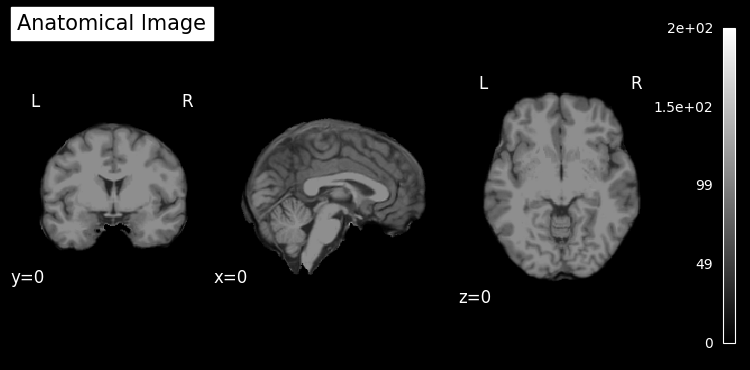

In [21]:
plotting.plot_anat(respective_brain, 
                   cut_coords=(0,0,0),
                   title='Anatomical Image', 
                   display_mode='ortho', # <-- display all the slices orientations
                   draw_cross=False) # <-- Do not draw a cross showing the cut      
plotting.show()

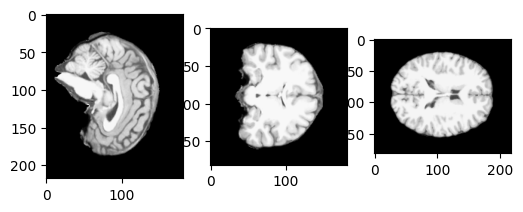

In [22]:
# For comparision, let's see normal visualizaiton method
respective_brain_data = respective_brain.get_fdata(dtype=np.float32)
fig, ax = plt.subplots(1,3,figsize=(6,18))
plot_points = [x//2 for x in respective_brain_data.shape[-3:]]
ax[0].imshow(respective_brain_data[plot_points[0]], cmap="Greys_r")
ax[1].imshow(respective_brain_data[:,plot_points[1]], cmap="Greys_r")
ax[2].imshow(respective_brain_data[:,:,plot_points[2]], cmap="Greys_r")
plt.show()

We can visualize the difference between the two brains.

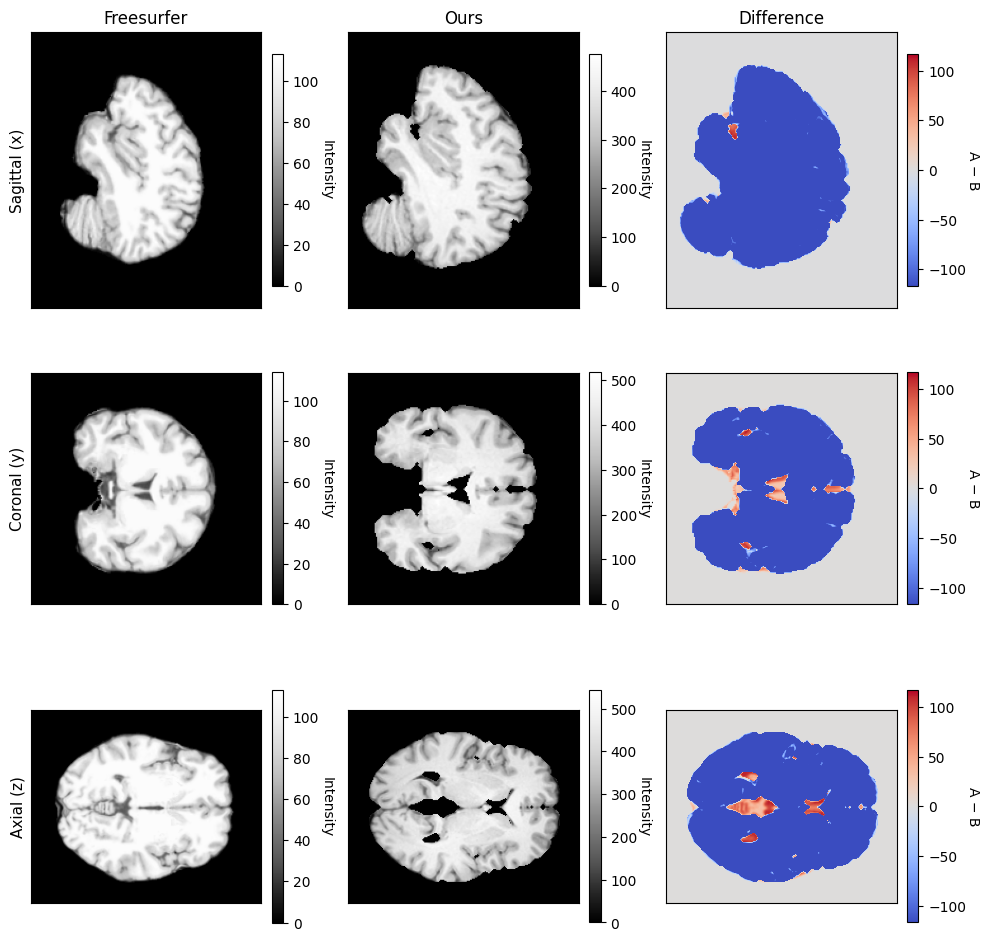

In [23]:
brain_skullstripped = brain_skullstripped_nii.get_fdata(dtype=np.float32)
diff = respective_brain_data - brain_skullstripped

def slc(vol, axis, idx):
    if axis == 0:   # sagittal (x)
        return vol[idx, :, :]
    elif axis == 1: # coronal (y)
        return vol[:, idx, :]
    elif axis == 2: # axial (z)
        return vol[:, :, idx]
    else:
        raise ValueError("axis must be 0, 1, or 2")

fig, ax = plt.subplots(3,3,figsize=(10,10))
plot_points = [x//2 for x in brain.shape[-3:]]

titles_cols = ["Freesurfer", "Ours", "Difference"]
titles_rows = ["Sagittal (x)", "Coronal (y)", "Axial (z)"]


for r, (axis, idx) in enumerate(zip([0, 1, 2], plot_points)):
    im0 = ax[r, 0].imshow(slc(respective_brain_data, axis, idx), cmap="Greys_r", origin="lower")
    im1 = ax[r, 1].imshow(slc(brain_skullstripped, axis, idx), cmap="Greys_r", origin="lower")
    im2 = ax[r, 2].imshow(slc(diff,   axis, idx), cmap="coolwarm",
                            vmin=-diff.max(), vmax=diff.max(), origin="lower")

    ax[r, 0].set_ylabel(titles_rows[r], fontsize=11)
    for c in range(3):
        ax[r, c].set_xticks([]); ax[r, c].set_yticks([])

    # Add compact colorbars on the right of each row for clarity
    cbar0 = fig.colorbar(im0, ax=ax[r, 0], fraction=0.046, pad=0.04)
    cbar1 = fig.colorbar(im1, ax=ax[r, 1], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=ax[r, 2], fraction=0.046, pad=0.04)
    cbar0.ax.set_ylabel("Intensity", rotation=270, labelpad=10)
    cbar1.ax.set_ylabel("Intensity", rotation=270, labelpad=10)
    cbar2.ax.set_ylabel("A − B",     rotation=270, labelpad=10)

for c in range(3):
    ax[0, c].set_title(titles_cols[c], fontsize=12)

plt.tight_layout()
plt.show()

You will that many differences are present. This is due to the different registration process happening behind the hood. The images I provided are skullstripped via `freesurfer` which executes a similar registration approach but only for identifying the brain mask and obtaining the final brain tissues. In fact, the brain is mantained in the same space as the original image (we can notice it is similar to the initial one). Afterwards, I applied a "rigid" registration to the MNI template, so that the final image we obtain is aligned to the MNI template, mantaing distances and angles inaltered.

# EDA

Now, let's study the distribution of our dataset

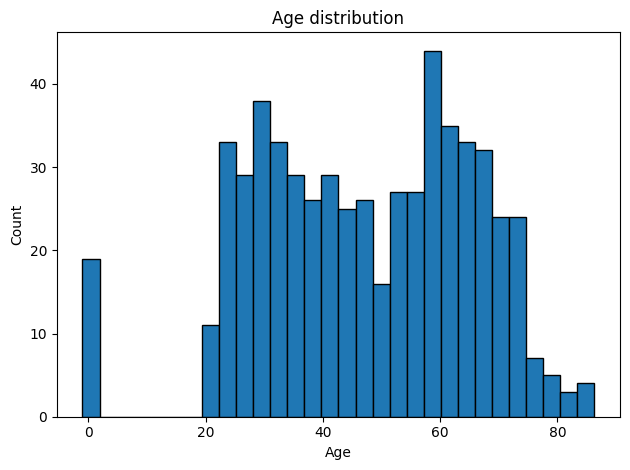

In [24]:
# Let's plot the age distribution to better visualize it
def plot_age_distribution_by(by=None):
    plt.figure()
    if by is None:
        plt.hist(masterfile['age'], bins=30, edgecolor='black')
        plt.title('Age distribution')
    else:
        groups = masterfile[by].unique()
        for g in groups:
            subset = masterfile[masterfile[by] == g]
            plt.hist(subset['age'], bins=30, alpha=0.5, label=f"{g} ({subset[by].count()})")
        plt.title(f'Age distribution by {by}')
        plt.legend()
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_age_distribution_by()

In [25]:
masterfile = masterfile[masterfile["age"] != -1]

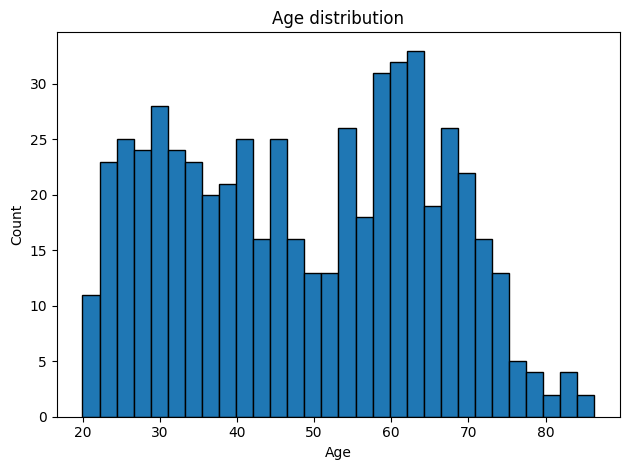

In [26]:
plot_age_distribution_by()

It seems the IXI dataset covers a good amount of age range. Let's see per scanner

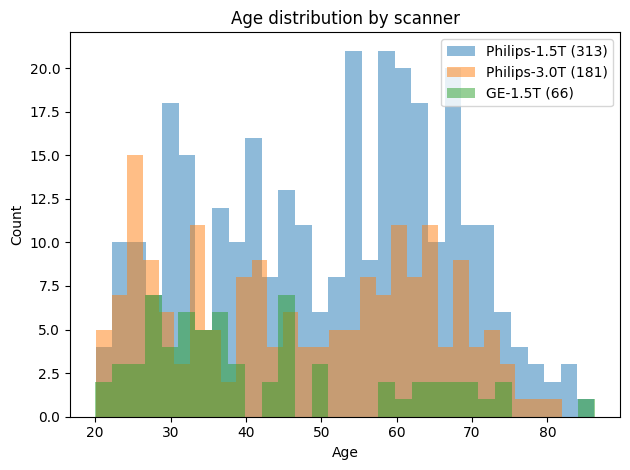

In [27]:
plot_age_distribution_by("scanner")

The study here show that each scanner covers a good amount of age distribution, with the GE-1.5T having some missing ages. Let's keep this in mind.
So age is not a problem. What about sex?

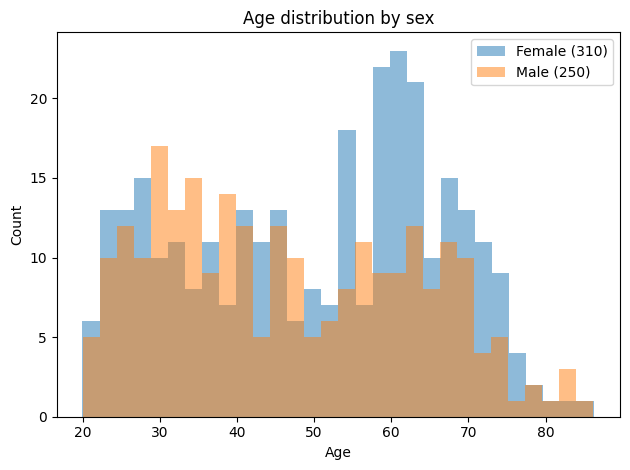

In [28]:
plot_age_distribution_by("sex")

We have a slight sex imbalance. This is something we will need to take into account when regressing age.

What other kind of relationship should we care about? 

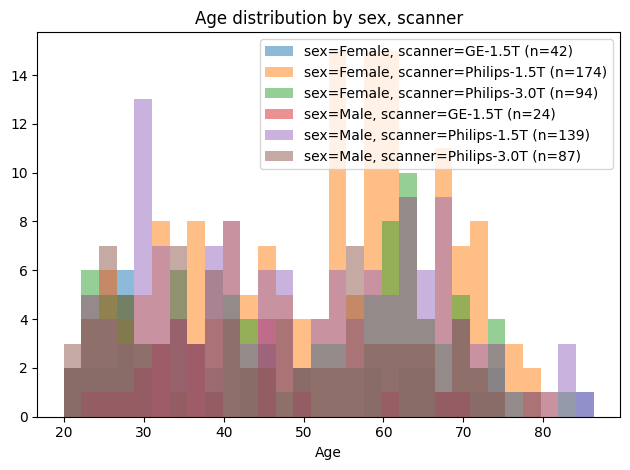

In [29]:
# Let's plot the age distribution to better visualize it
def plot_age_distribution_by_mul(by=None):
    ages = masterfile['age']

    def _label_from_key(key, by_cols):
        if isinstance(by_cols, (list, tuple)):
            if not isinstance(key, tuple):
                key = (key,)
            return ", ".join(f"{col}={val}" for col, val in zip(by_cols, key))
        else:
            return f"{by_cols}={key}"

    plt.figure()
    if by is None:
        plt.hist(ages, bins=30, edgecolor='black')
        plt.title('Age distribution')
    else:
        by_cols = [by] if isinstance(by, str) else list(by)
        bin_edges = np.histogram_bin_edges(ages, bins=30)

        for key, sub in masterfile.groupby(by_cols):
            plt.hist(
                sub['age'],
                bins=bin_edges,
                alpha=0.5,
                label=f"{_label_from_key(key, by_cols)} (n={len(sub)})"
            )
        title_by = ", ".join(by_cols)
        plt.title(f'Age distribution by {title_by}')
        plt.legend()

    plt.xlabel('Age')
    plt.tight_layout()
    plt.show()

plot_age_distribution_by_mul(by=["sex", "scanner"])

Slight unbalance on female/male for Philips. This will be evident in regression!

The masterfile provide also a thickness. The thickness is the estimated surface cortical thickness per voxel extracted via `freesurfer`. Let's visualize it for a generic candidate.

In [30]:
example_thickness_file = "../data/example_data/sub-IXI002_acq-Philips-1.5T_hemi-L_thickness"
lh_thickness_values = read_morph_data(example_thickness_file)
lh_thickness_values.shape

(131103,)

These are the cortical thickness values of the left emisphere per-vertex map.
Cortical Thickness values are very useful since they provide a numeric quantity that is more structure than plain images/volumes of the brain.

However, there is as you can see an extremely high dimensionality. We can reduce this values to a per-region average.
In the file I provided, you can find the already averaged annotations (`../notebooks/additional/get_averaged_regions.ipynb` gives you a glimpse of how this can be done).

In [24]:
thickness_df = pd.read_csv("../data/IXI/thickness.csv")
thickness_df

,subject_id,hemi,region,mean_thickness_weighted,mean_thickness_simple,n_vertices,total_area
0,IXI002,lh,unknown,0.000369,0.000338,8853,5502.432653
1,IXI002,lh,caudalanteriorcingulate,2.767575,2.609781,1437,1083.926104
2,IXI002,lh,caudalmiddlefrontal,2.828643,2.690581,3830,2769.405243
3,IXI002,lh,cuneus,2.019888,2.020947,2739,2037.500121
4,IXI002,lh,entorhinal,2.712761,2.636525,708,687.427367
...,...,...,...,...,...,...,...
37063,IXI662,rh,superiorparietal,2.120859,2.023058,6653,5314.046982
37064,IXI662,rh,superiortemporal,2.965944,2.796967,8804,7119.010455
37065,IXI662,rh,supramarginal,2.508402,2.370133,5606,4399.206890
37066,IXI662,rh,transversetemporal,2.354042,2.350365,628,446.668808


As you can see, we have aggregated the values per region, which will allow us an easier analysis in further steps of our lessons.